In [1]:
import xarray as xr
import datetime
import numpy as np
import pandas as pd

In [2]:
def flip_lon_360_2_180(var_360, lon):
    """
    This function shifts the longitude dimension from [0,360] to [-180,180].
    """
    try:
        var_180 = var_360.assign_coords(lon=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.lon)
    except:
        var_180 = var_360.assign_coords(longitude=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.longitude)

    return var_180

def from_init_time_to_leadtime(var_init_time, init_time_min, lead_time_range, time_range):
    """
    This function creates a xarray DataArray for a given variable and fills it with values based on the provided time range and lead time range.

    Parameters:
    var_init_time (xarray.DataArray): The initial time data for the variable.
    init_time_min (datetime): The minimum initial time.
    lead_time_range (numpy.ndarray): The range of lead times.
    time_range (pandas.DatetimeIndex): The range of times.

    Returns:
    xarray.DataArray: The created and filled DataArray for the variable.
    """

    # Create a new DataArray for the variable with extra dimensions
    dims = ["lead_time", "time"] + list(var_init_time.dims)[2:]
    coords = {"lead_time": lead_time_range, "time": time_range}
    coords.update({dim: var_init_time.coords[dim] for dim in var_init_time.dims[2:]})
    var_leadtime = xr.DataArray(dims=dims, coords=coords)
    
    # Loop to assign values
    for t in time_range:
        for lt in lead_time_range:
            # Convert the numpy datetime64 object to a Python datetime object
            t_datetime = pd.to_datetime(str(t.values))

            # Subtract the timedelta
            it = t_datetime - datetime.timedelta(hours=int(lt))

            # Assign NaN if the initial time is less than the minimum initial time
            if it < init_time_min:
                var_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan
            else:
                try:
                    # Assign the value from the initial time data for the variable
                    var_leadtime.loc[{"lead_time": lt, "time": t}] = var_init_time.sel(init_time=it, time=t)
                except:
                    # Assign NaN if the value cannot be assigned
                    var_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan

    return var_leadtime

In [3]:
#we want to run our model for different dates
t0_i = datetime.datetime(2023,10,25,0)
t0_f = datetime.datetime(2023,11,2,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [4]:
def load_data(var, init_times):
    var_inits = []
    for t0 in init_times:
        yyyymmddhh = t0.strftime('%Y%m%d%H')    
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file)[var]
        var_inits.append(ds)
    merged_dataset = xr.concat(var_inits, dim='init_time')
    return merged_dataset.assign_coords(init_time=init_times)

In [5]:
msl = load_data('msl',init_times)

In [6]:
#load data

msl = load_data('msl',init_times)
v10 = load_data('v10m', init_times)
u10 = load_data('u10m', init_times)
tcwv = load_data('tcwv', init_times)
    

In [7]:
#selct are we are interested
lat_slice=slice(55,40)
lon_slice=slice(-40,10)
time_slice=slice('2023-10-25', '2023-11-02')

# Assuming data is your 2D array
msl_area = flip_lon_360_2_180(msl,msl.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)
u10_area = flip_lon_360_2_180(u10,u10.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)
v10_area = flip_lon_360_2_180(v10,v10.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)
tcwv_area = flip_lon_360_2_180(tcwv,tcwv.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)

In [8]:
wsp10_area  = np.sqrt(u10_area**2 + v10_area**2)

we do not need to loead era5 data. it is always encoded as in the first timestep

In [9]:
#from init time to lead time
time_range = msl_area.time.sel(time=slice('2023-10-25','2023-11-05'))
init_time_min = datetime.datetime(2018, 10, 25, 0)
lead_time_range = np.arange(0,10*24,6)

msl_leadtime = from_init_time_to_leadtime(msl_area, init_time_min, lead_time_range, time_range)
wsp10_leadtime = from_init_time_to_leadtime(wsp10_area, init_time_min, lead_time_range, time_range)
tcwv_leadtime = from_init_time_to_leadtime(tcwv_area, init_time_min, lead_time_range, time_range)

In [10]:
msl_bias = msl_leadtime - msl_leadtime[0]
wsp10_bias = wsp10_leadtime - wsp10_leadtime[0]
tcwv_bias = tcwv_leadtime - tcwv_leadtime[0]

/tmp/ipykernel_2103220/3313218725.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('plasma_r', 256)


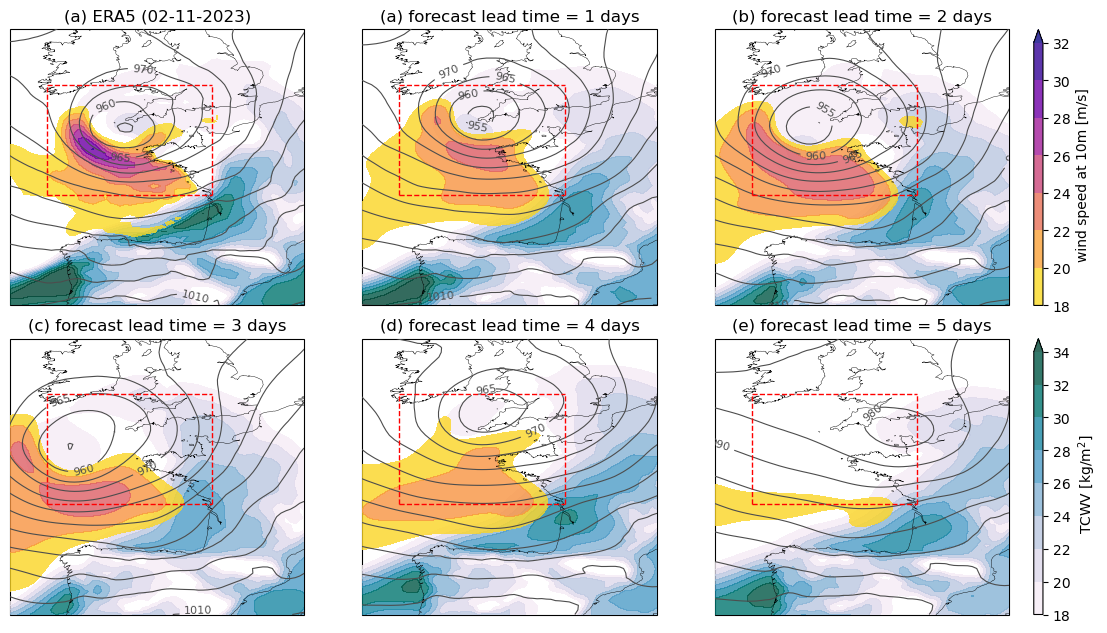

In [400]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(2,3, sharey=True, sharex=True, figsize=(13,6.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))
axes = axes.flatten()
# Create color map
colors = mpl.cm.get_cmap('plasma_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[0:2, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)
lts=[4,8,12,18,22]

lonW, lonE = -10, -1
latN, latS = 52, 46
letter=['a','b','c','d','e','f', 'g', 'h']

for ax in axes:
    ax.plot([lonW,lonE],[latS,latS], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree(),zorder=108)
    ax.plot([lonW,lonE],[latN,latN],  lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree(),zorder=108)
    ax.plot([lonW,lonW],[latS,latN], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree(),zorder=108)
    ax.plot([lonE,lonE],[latS,latN], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree(),zorder=108)
    ax.set_xlim([-12,4])
    ax.set_ylim([40,55])
    ax.coastlines(lw=0.3, color='k',zorder=105)

#figure 1
cf0 = axes[0].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, wsp10_leadtime[0].sel(time='2023-11-02-00'), cmap=newcmap,\
                       levels=np.arange(18,33.1,2), extend='max',alpha=0.8,zorder=102)
cf01 = axes[0].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, tcwv_leadtime[0].sel(time='2023-11-02-00'), cmap='PuBuGn',\
                        levels=np.arange(18,34.1,2), extend='max', alpha=0.8,zorder=101)
con0 = axes[0].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[0].sel(time='2023-11-02-00')*0.01, colors='0.3', \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
plt.clabel(con0, fontsize=8, fmt='%1.0f')
axes[0].set_title(r'\textbf{a} ERA5 (02-11-2023 0UTC)')
#figure 2
for i,lt in enumerate(lts):
    cf1 = axes[1+i].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, wsp10_leadtime[lt].sel(time='2023-11-02-00'), cmap=newcmap,\
                       levels=np.arange(18,33.1,2.5), extend='max',alpha=0.8,zorder=102)
    cf11 = axes[1+i].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, tcwv_leadtime[lt].sel(time='2023-11-02-00'), cmap='PuBuGn',\
                        levels=np.arange(18,34.1,2), extend='max',alpha=0.8,zorder=101)
    con1 = axes[1+i].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors='0.3',\
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
    plt.clabel(con1, fontsize=8, fmt='%1.0f')
    axes[1+i].set_title(fr'\textbf{{letter[i]}} forecast lead time = {int(lt/4)} days')

#figure 3
#cf2 = axes[2].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, tcwv_leadtime[lt].sel(time='2023-11-02-00'), cmap='PuBuGn',levels=np.arange(10,40.1,2), extend='both')
#con2 = axes[2].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[0].sel(time='2023-11-02-00')*0.01, colors='g', linewidths=0.8 ,levels=np.arange(960,1035,5))

# Adjust size
f.subplots_adjust(hspace=0.12, wspace=0.1, left=0.0, right=0.95, bottom=0.05, top=0.95)

cbar1 = plt.colorbar(cf0, ax=axes[0:3], label='wind speed at 10m [m/s]', pad=0.02, orientation='vertical', shrink=1.0, aspect=30)
cbar2 = plt.colorbar(cf01, ax=axes[3:7], label=r'TCWV [kg/m$^2$]', pad=0.02, orientation='vertical', shrink=1.0, aspect=30)

plt.savefig('extratropical_storm_predictability_evolution.pdf',bbox_inches='tight')

In [11]:
def load_data_deltas(var, init_times, models):
    var_inits_model = []
    for model in models:
        print(model)
        var_inits = []
        for t0 in init_times:
            yyyymmddhh = t0.strftime('%Y%m%d%H')    
            file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
            ds = xr.open_dataset(file)[var]
            var_inits.append(ds)
        var_inits_model.append(xr.concat(var_inits, dim='init_time'))
    merged_dataset = xr.concat(var_inits_model, dim='model')
    return merged_dataset.assign_coords(init_time=init_times,model=models)


In [12]:
u10_pgw = load_data_deltas('u10m',init_times,['multimodel']).squeeze()
v10_pgw = load_data_deltas('v10m',init_times,['multimodel']).squeeze()
msl_pgw = load_data_deltas('msl',init_times,['multimodel']).squeeze()
tcwv_pgw = load_data_deltas('tcwv',init_times,['multimodel']).squeeze()

multimodel
multimodel
multimodel
multimodel


In [13]:
#selct are we are interested
lat_slice=slice(60,40)
lon_slice=slice(-40,10)
time_slice=slice('2023-10-25', '2023-11-02')

# Assuming data is your 2D array
u10_pgw_area = flip_lon_360_2_180(u10_pgw,u10_pgw.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)
v10_pgw_area = flip_lon_360_2_180(v10_pgw,v10_pgw.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)
tcwv_pgw_area = flip_lon_360_2_180(tcwv_pgw,tcwv_pgw.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)
msl_pgw_area = flip_lon_360_2_180(msl_pgw,msl_pgw.lon).sel(lat=lat_slice,lon=lon_slice, time=time_slice)

In [14]:
wsp10_pgw_area  = np.sqrt(u10_pgw_area**2 + v10_pgw_area**2)

In [54]:
#from init time to lead time
time_range = msl_area.time.sel(time=slice('2023-10-25','2023-11-05'))
init_time_min = datetime.datetime(2018, 10, 25, 0)
lead_time_range = np.arange(0,10*24,6)

wsp10_pgw_leadtime = from_init_time_to_leadtime(wsp10_pgw_area, init_time_min, lead_time_range, time_range)
msl_pgw_leadtime = from_init_time_to_leadtime(msl_pgw_area, init_time_min, lead_time_range, time_range)
tcwv_pgw_leadtime = from_init_time_to_leadtime(tcwv_pgw_area, init_time_min, lead_time_range, time_range)

In [104]:
diff_wsp10_pgw_leadtime = (wsp10_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00') - \
                            wsp10_pgw_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00')).mean('lead_time')
diff_msl_pgw_leadtime = (msl_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00') - \
                        msl_pgw_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00')).mean('lead_time') 
diff_tcwv_pgw_leadtime = (tcwv_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00') - \
                        tcwv_pgw_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00')).mean('lead_time') 

In [ ]:
diff_wsp10_pgw_leadtime = wsp10_leadtime.sel() - wsp10_pgw_leadtime 
diff_msl_pgw_leadtime = msl_leadtime - msl_pgw_leadtime 
diff_tcwv_pgw_leadtime = tcwv_leadtime - tcwv_pgw_leadtime 

In [108]:
from scipy import stats

#significance:
sample1= wsp10_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00').values
sample2= wsp10_pgw_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00').values
_, p_value_wsp10 = stats.ttest_ind(sample1, sample2, axis=0)

sample1= msl_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00').values
sample2= msl_pgw_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00').values
_, p_value_msl = stats.ttest_ind(sample1, sample2, axis=0)

sample1= tcwv_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00').values
sample2= tcwv_pgw_leadtime.sel(lead_time=slice(1*24,3*24)).sel(time='2023-11-02-00').values
_, p_value_tcwv = stats.ttest_ind(sample1, sample2, axis=0)

/tmp/ipykernel_433538/3498504440.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('plasma_r', 256)
/tmp/ipykernel_433538/3498504440.py:38: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in sig0.collections:
/tmp/ipykernel_433538/3498504440.py:51: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in sig1.collections:
/tmp/ipykernel_433538/3498504440.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in sig2.collections:


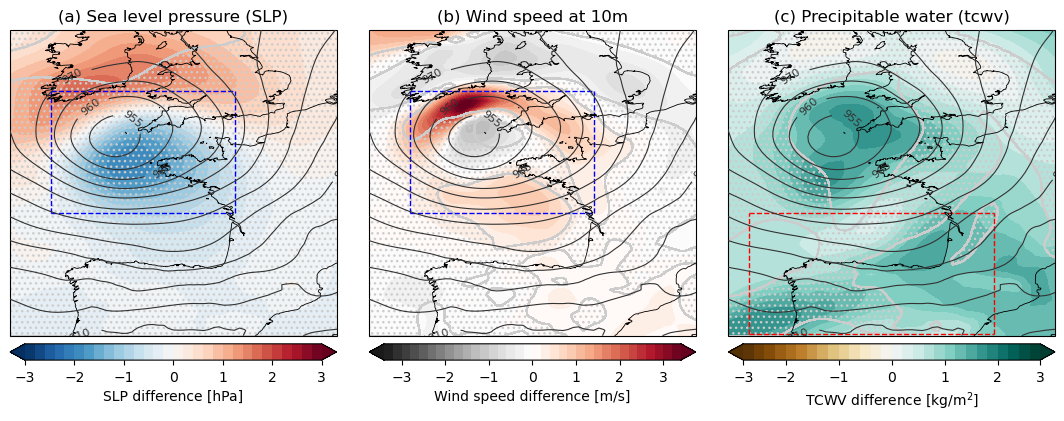

In [114]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(1,3, sharey=True, sharex=True, figsize=(11,4.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

# Create color map
colors = mpl.cm.get_cmap('plasma_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[0:2, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lt=8 #2 days


lonW, lonE = -10, -1
latN, latS = 52, 46
for ax in axes[0:2]:
    ax.plot([lonW,lonE],[latS,latS], lw='1.0', ls='--', color='b',transform=ccrs.PlateCarree())
    ax.plot([lonW,lonE],[latN,latN],  lw='1.0', ls='--', color='b',transform=ccrs.PlateCarree())
    ax.plot([lonW,lonW],[latS,latN], lw='1.0', ls='--', color='b',transform=ccrs.PlateCarree())
    ax.plot([lonE,lonE],[latS,latN], lw='1.0', ls='--', color='b',transform=ccrs.PlateCarree())

for ax in axes:
    ax.set_xlim([-12,4])
    ax.set_ylim([40,55])
    ax.coastlines(lw=0.6, color='k',zorder=105)

#plot1: SLP change
cf0 = axes[0].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, diff_msl_pgw_leadtime*0.01, \
                      cmap='RdBu_r',levels=np.arange(-3,3.1,0.2), extend='both')
con0 = axes[0].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['0.2'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
sig0 = axes[0].contourf(msl_bias.lon, msl_bias.lat, p_value_msl, colors='none', levels=[0.05,1], hatches=['...',''])
for collection in sig0.collections:
    collection.set_edgecolor('0.8')  # Set the hatch color to red
cbar0 = plt.colorbar(cf0, ax=axes[0], label='SLP difference [hPa]', pad=0.02, orientation='horizontal', shrink=1.0, aspect=20)
axes[0].set_title('(a) Sea level pressure (SLP)')
plt.clabel(con0, fontsize=8, fmt='%1.0f')


#plot2: WSP change
cf1 = axes[1].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, diff_wsp10_pgw_leadtime,\
                      cmap='RdGy_r',levels=np.arange(-3.4,3.6,0.2), extend='both')
con1 = axes[1].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['0.2'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
sig1 = axes[1].contourf(msl_bias.lon, msl_bias.lat, p_value_wsp10, colors='none', levels=[0.5,1], hatches=['...',''])
for collection in sig1.collections:
    collection.set_edgecolor('0.8')  # Set the hatch color to red
    
cbar1 = plt.colorbar(cf1, ax=axes[1], label='Wind speed difference [m/s]', pad=0.02, orientation='horizontal', shrink=1.0, aspect=20)
axes[1].set_title('(b) Wind speed at 10m')
plt.clabel(con1, fontsize=8, fmt='%1.0f')


#plot2: TCWV change
cf2 = axes[2].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, diff_tcwv_pgw_leadtime,\
                      cmap='BrBG',levels=np.arange(-2.8,2.9,0.2), extend='both')
con2 = axes[2].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['0.2'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
sig2 = axes[2].contourf(msl_bias.lon, msl_bias.lat, p_value_tcwv, colors='none', levels=[0.05,1], hatches=['...',''])
for collection in sig2.collections:
    collection.set_edgecolor('0.8')  # Set the hatch color to red
plt.clabel(con2, fontsize=8, fmt='%1.0f')
axes[2].set_title('(c) Precipitable water (tcwv)')
cbar2 = plt.colorbar(cf2, ax=axes[2], label=r'TCWV difference [kg/m$^2$]', pad=0.02, orientation='horizontal', shrink=1.0, aspect=20)

lonW, lonE = -11, 1
latN, latS = 46, 40.1
axes[2].plot([lonW,lonE],[latS,latS], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())
axes[2].plot([lonW,lonE],[latN,latN],  lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())
axes[2].plot([lonW,lonW],[latS,latN], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())
axes[2].plot([lonE,lonE],[latS,latN], lw='1.0', ls='--', color='r',transform=ccrs.PlateCarree())

# Custom ticks and labels
ticks = np.arange(-3,3.1,1)
cbar0.set_ticks(ticks)
cbar1.set_ticks(ticks)
cbar2.set_ticks(ticks)

# Adjust size
f.subplots_adjust(hspace=0.12, wspace=0.1, left=0.0, right=0.95, bottom=0.05, top=0.95)
plt.savefig('extratropical_storm_PGW_attribution_mapplot_slp_wsp_tcwv.pdf',bbox_inches='tight')

In [45]:
max_wsp10_leadtime =  wsp10_leadtime.sel(time='2023-11-02-00', lat=slice(52,46), lon=slice(-10,-1)).max(['lat','lon'])
max_wsp10_pgw_leadtime =  wsp10_pgw_leadtime.sel(time='2023-11-02-00', lat=slice(52,46), lon=slice(-10,-1)).max(['lat','lon'])

In [46]:
max_tcwv_leadtime =  tcwv_leadtime.sel(time='2023-11-02-00', lat=slice(46,40), lon=slice(-11,1)).max(['lat','lon'])
max_tcwv_pgw_leadtime =  tcwv_pgw_leadtime.sel(time='2023-11-02-00', lat=slice(46,40), lon=slice(-11,1)).max(['lat','lon'])

In [49]:
min_msl_leadtime =  msl_leadtime.sel(time='2023-11-02-00', lat=slice(52,46), lon=slice(-10,-1)).min(['lat','lon'])
min_msl_pgw_leadtime =  msl_pgw_leadtime.sel(time='2023-11-02-00', lat=slice(52,46), lon=slice(-10,-1)).min(['lat','lon'])

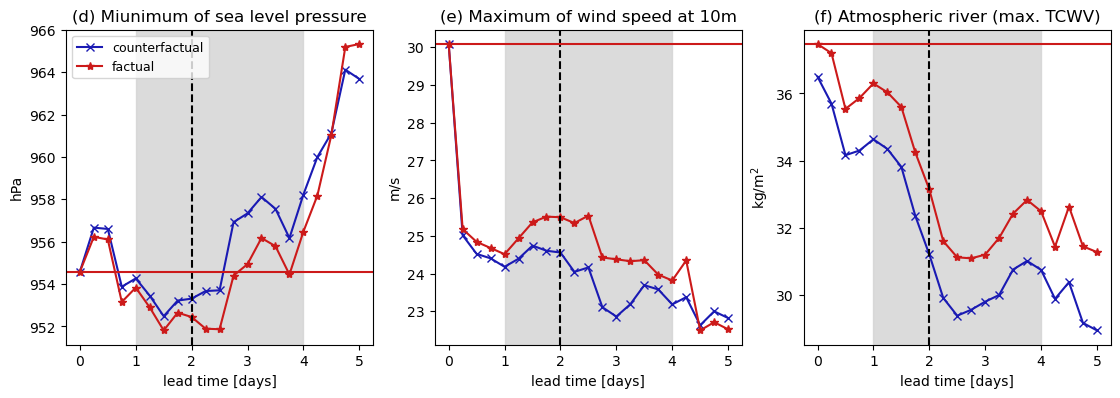

In [110]:
# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(1,3, sharey=False, sharex=False, figsize=(11,3.5))


lt_1, lt_2 = 0, int(5*4) #2 days
leadtimes = min_msl_pgw_leadtime[lt_1:lt_2+1].lead_time
colors = [(0.1,0.1,0.7),(0.8,0.1,0.1)]

#plot1: SLP change
line1 = axes[0].plot(leadtimes,min_msl_pgw_leadtime[lt_1:lt_2+1]*0.01, color=colors[0], marker='x',label='counterfactual')
line2 = axes[0].plot(leadtimes,min_msl_leadtime[lt_1:lt_2+1]*0.01, color=colors[1], label='factual', marker='*')
axes[0].legend(fontsize=9,loc='upper left')

# Add a filled background between the vertical lines
axes[0].axvline(x=2*24, color='k', linestyle='--')
axes[0].axhline(y=min_msl_pgw_leadtime[0]*0.01, color=colors[1], linestyle='-')
axes[0].set_ylabel(r'hPa')
axes[0].set_title(f'(d) Miunimum of sea level pressure')

#plot2: WSP change
line1 = axes[1].plot(leadtimes,max_wsp10_pgw_leadtime[lt_1:lt_2+1], color=colors[0], marker='x')
line2 = axes[1].plot(leadtimes,max_wsp10_leadtime[lt_1:lt_2+1], color=colors[1], marker='*')

# Add a filled background between the vertical lines
axes[1].axvline(x=2*24, color='k', linestyle='--')
axes[1].axhline(y=max_wsp10_pgw_leadtime[0], color=colors[1], linestyle='-')
axes[1].set_title(f'(e) Maximum of wind speed at 10m')
axes[1].set_ylabel('m/s')

#plot2: TCWV change
line1 = axes[2].plot(leadtimes,max_tcwv_pgw_leadtime[lt_1:lt_2+1], color=colors[0], marker='x')
line2 = axes[2].plot(leadtimes,max_tcwv_leadtime[lt_1:lt_2+1], color=colors[1], marker='*')

# Add a filled background between the vertical lines
axes[2].axvline(x=2*24, color='k', linestyle='--')
axes[2].axhline(y=max_tcwv_leadtime[0], color=colors[1], linestyle='-')
axes[2].set_title(f'(f) Atmospheric river (max. TCWV)')
axes[2].set_ylabel(r'kg/m$^2$')

#x-axis
for ax in axes:
    ax.set_xlabel('lead time [days]')
    ax.set_xticks([0,24,48,72,96,120])
    ax.set_xticklabels([0,1,2,3,4,5])
    # Add a filled background between the vertical lines
    ax.axvspan(1*24, 4*24, color='lightgray', alpha=0.8)

# Adjust size
f.subplots_adjust(hspace=0.12, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)
plt.savefig('extratropical_storm_leadtime_PGW_attribution.pdf',bbox_inches='tight')

In [81]:
#plot showing the ensemble spread
wsp10_leadtime_std = wsp10_leadtime.sel(lead_time=slice(24,24*4),time='2023-11-02-00').std('lead_time')
msl_leadtime_std = msl_leadtime.sel(lead_time=slice(24,24*4),time='2023-11-02-00').std('lead_time')
tcwv_leadtime_std = tcwv_leadtime.sel(lead_time=slice(24,24*4),time='2023-11-02-00').std('lead_time')

wsp10_pgw_leadtime_std = wsp10_pgw_leadtime.sel(lead_time=slice(24,24*4),time='2023-11-02-00').std('lead_time')
msl_pgw_leadtime_std = msl_pgw_leadtime.sel(lead_time=slice(24,24*4),time='2023-11-02-00').std('lead_time')
tcwv_pgw_leadtime_std = tcwv_pgw_leadtime.sel(lead_time=slice(24,24*4),time='2023-11-02-00').std('lead_time')

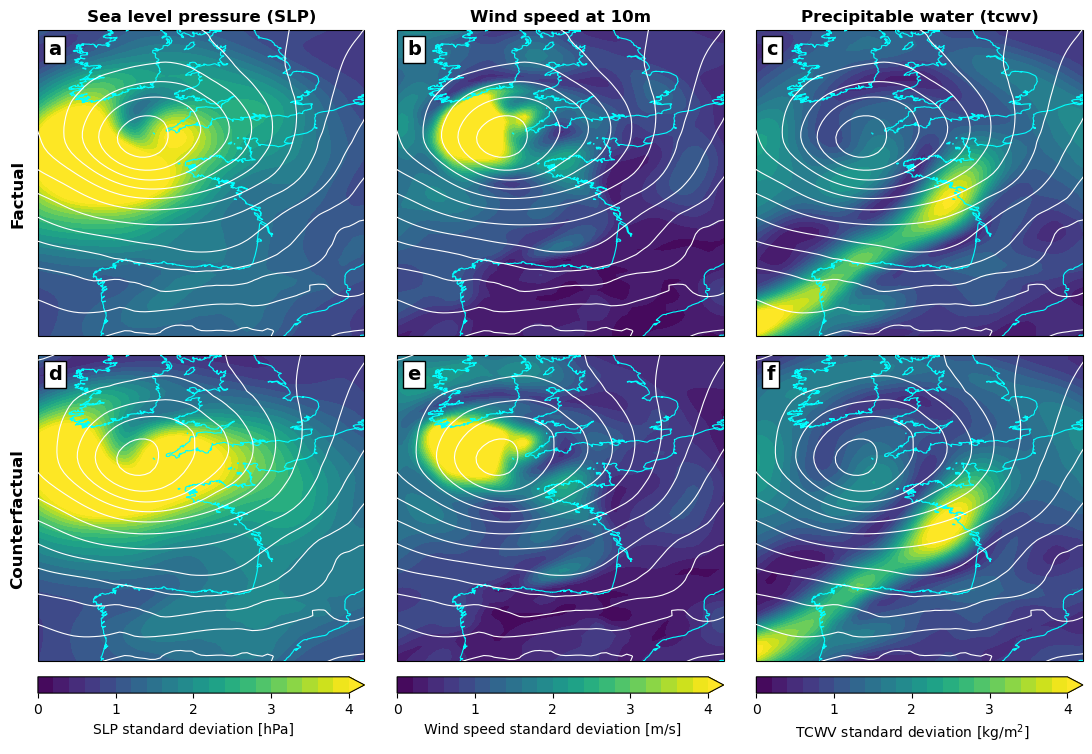

In [113]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(2,3, sharey=True, sharex=True, figsize=(11,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))


lonW, lonE = -10, -1
latN, latS = 52, 46

alphabet_list = [chr(i) for i in range(ord('a'), ord('a') + 15)]
for i,ax in enumerate(axes.flatten()):
    ax.set_xlim([-12,4])
    ax.set_ylim([40,55])
    ax.coastlines(lw=0.8, color='cyan',zorder=105)
    ax.text(-11.5, 53.8, alphabet_list[i], fontsize=14, color='0.0', fontweight='bold',
           bbox=dict(facecolor='white', edgecolor='k', pad=3.0))

#plot1: SLP change
cf0 = axes[0,0].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, msl_leadtime_std*0.01, \
                      cmap='viridis',levels=np.arange(0,4.1,0.2), extend='max')
con0 = axes[0,0].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['1.0'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
cf0 = axes[1,0].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, msl_pgw_leadtime_std*0.01, \
                      cmap='viridis',levels=np.arange(0,4.1,0.2), extend='max')
con0 = axes[1,0].contour(msl_bias.lon, msl_bias.lat, msl_pgw_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['1.0'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)

axes[0,0].set_title('Sea level pressure (SLP)',fontweight='bold')


#plot2: WSP change
cf1 = axes[0,1].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, wsp10_leadtime_std,\
                      cmap='viridis',levels=np.arange(0,4.1,0.2), extend='max')
con1 = axes[0,1].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['1.0'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
cf1 = axes[1,1].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, wsp10_pgw_leadtime_std, \
                      cmap='viridis',levels=np.arange(0,4.1,0.2), extend='max')
con1 = axes[1,1].contour(msl_bias.lon, msl_bias.lat, msl_pgw_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['1.0'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
axes[0,1].set_title('Wind speed at 10m',fontweight='bold')


#plot2: TCWV change
cf2 = axes[0,2].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, tcwv_leadtime_std,\
                      cmap='viridis',levels=np.arange(0,4.1,0.2), extend='max')
con2 = axes[0,2].contour(msl_bias.lon, msl_bias.lat, msl_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['1.0'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
cf0 = axes[1,2].contourf(wsp10_leadtime.lon, wsp10_leadtime.lat, tcwv_pgw_leadtime_std, \
                      cmap='viridis',levels=np.arange(0,4.1,0.2), extend='max')
con0 = axes[1,2].contour(msl_bias.lon, msl_bias.lat, msl_pgw_leadtime[lt].sel(time='2023-11-02-00')*0.01, colors=['1.0'], \
                       linewidths=0.8 ,levels=np.arange(950,1035,5), zorder=106)
axes[0,2].set_title('Precipitable water (tcwv)',fontweight='bold')


side_text= 'Factual'
axes[0,0].text(-13, 47, side_text, rotation=90,verticalalignment='center', horizontalalignment='center', fontsize=12, fontweight='bold')
side_text= 'Counterfactual'
axes[1,0].text(-13, 47, side_text, rotation=90,verticalalignment='center', horizontalalignment='center', fontsize=12, fontweight='bold')

# Adjust size
f.subplots_adjust(hspace=0.05, wspace=0.1, left=0.0, right=0.95, bottom=0.05, top=0.95)

cbar0 = plt.colorbar(cf0, ax=axes[:,0], label='SLP standard deviation [hPa]', pad=0.02, orientation='horizontal', shrink=1.0, aspect=20)
cbar1 = plt.colorbar(cf1, ax=axes[:,1], label='Wind speed standard deviation [m/s]', pad=0.02, orientation='horizontal', shrink=1.0, aspect=20)
cbar2 = plt.colorbar(cf2, ax=axes[:,2], label=r'TCWV standard deviation [kg/m$^2$]', pad=0.02, orientation='horizontal', shrink=1.0, aspect=20)

# Custom ticks and labels
ticks = np.arange(0,4.1,1)
cbar0.set_ticks(ticks)
cbar1.set_ticks(ticks)
cbar2.set_ticks(ticks)

plt.savefig('extratropical_storm_uncertainty_stddev_lt_1-4days_wsp_slp_tcwv.pdf',bbox_inches='tight')